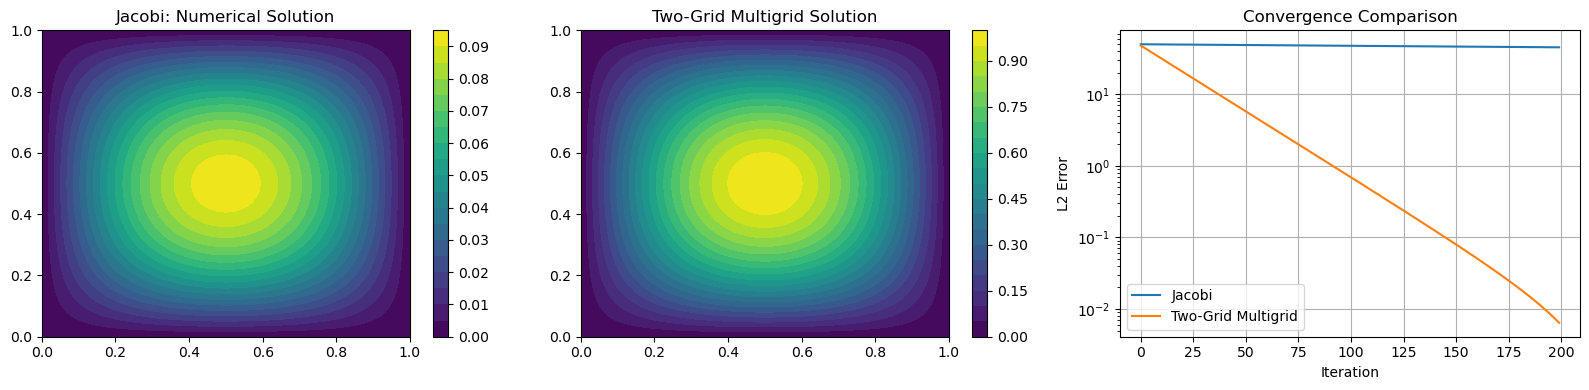

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- 基础设置 ---
nx, ny = 101, 101  # 使用65x65的细网格（包含边界）
Lx, Ly = 1.0, 1.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# 右端项和解析解
def rhs_func(x, y):
    return -2 * (np.pi ** 2) * np.sin(np.pi * x) * np.sin(np.pi * y)

def analytical_solution(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

f = rhs_func(X, Y)
p_exact = analytical_solution(X, Y)

# --- 辅助函数 ---
def jacobi(u, f, dx, dy, num_iter=5):
    u_new = u.copy()
    for _ in range(num_iter):
        u_old = u_new.copy()
        u_new[1:-1, 1:-1] = 0.25 * (
            u_old[2:, 1:-1] + u_old[:-2, 1:-1] +
            u_old[1:-1, 2:] + u_old[1:-1, :-2] -
            f[1:-1, 1:-1] * dx * dy
        )
    return u_new

def compute_residual(u, f, dx, dy):
    r = np.zeros_like(u)
    r[1:-1, 1:-1] = f[1:-1, 1:-1] - (
        (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2 +
        (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2
    )
    return r

def restrict(res):
    return 0.25 * (res[0:-1:2,0:-1:2] + res[1::2,0:-1:2] + res[0:-1:2,1::2] + res[1::2,1::2])

# 修复 prolong 以返回与原网格大小匹配的矩阵（65x65）
def prolong_fixed(e, target_shape):
    nx, ny = e.shape
    fine = np.zeros((2*nx - 1, 2*ny - 1))
    fine[::2, ::2] = e
    fine[1::2, ::2] = 0.5 * (e[:-1,:] + e[1:,:])
    fine[::2, 1::2] = 0.5 * (e[:,:-1] + e[:,1:])
    fine[1::2, 1::2] = 0.25 * (e[:-1,:-1] + e[1:,:-1] + e[:-1,1:] + e[1:,1:])
    
    # 填补边界，pad到目标大小
    pad_x = target_shape[0] - fine.shape[0]
    pad_y = target_shape[1] - fine.shape[1]
    fine_padded = np.pad(fine, ((0, pad_x), (0, pad_y)), mode='constant')
    return fine_padded

# 修改 two_grid_v_cycle 使用新的 prolong_fixed
def two_grid_v_cycle_fixed(u, f, dx, dy, pre_smooth=3, post_smooth=3):
    # 1. 预平滑
    u = jacobi(u, f, dx, dy, pre_smooth)
    
    # 2. 计算残差
    r = compute_residual(u, f, dx, dy)
    
    # 3. 限制残差到粗网格
    r_coarse = restrict(r)
    nxc, nyc = r_coarse.shape
    uc = np.zeros((nxc, nyc))
    f_coarse = r_coarse
    
    # 4. 在粗网格上解误差（几次Jacobi）
    h_coarse = dx * 2
    ec = jacobi(uc, f_coarse, h_coarse, h_coarse, num_iter=20)
    
    # 5. 内插误差并修正
    efine = prolong_fixed(ec, u.shape)
    u += efine
    
    # 6. 后平滑
    u = jacobi(u, f, dx, dy, post_smooth)
    
    return u

# --- 运行Jacobi方法 ---
p_jacobi = np.zeros_like(f)
tol = 1e-6
max_iter = 200
errors_jacobi = []

for it in range(max_iter):
    p_old = p_jacobi.copy()
    p_jacobi = jacobi(p_old, f, dx, dy, num_iter=1)
    err = np.linalg.norm(p_jacobi - p_exact, ord=2)
    errors_jacobi.append(err)
    if err < tol:
        break

# 重新运行 Multigrid 方法
p_mg_fixed = np.zeros_like(f)
errors_mg_fixed = []

for it in range(200):
    p_mg_fixed = two_grid_v_cycle_fixed(p_mg_fixed, f, dx, dy, pre_smooth=3, post_smooth=3)
    err = np.linalg.norm(p_mg_fixed - p_exact, ord=2)
    errors_mg_fixed.append(err)
    if err < tol:
        break
# --- 可视化 ---
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

cs0 = axs[0].contourf(X, Y, p_jacobi, 20, cmap='viridis')
fig.colorbar(cs0, ax=axs[0])
axs[0].set_title("Jacobi: Numerical Solution")

cs1 = axs[1].contourf(X, Y, p_mg_fixed, 20, cmap='viridis')
fig.colorbar(cs1, ax=axs[1])
axs[1].set_title("Two-Grid Multigrid Solution")

axs[2].semilogy(errors_jacobi, label='Jacobi')
axs[2].semilogy(errors_mg_fixed, label='Two-Grid Multigrid')
axs[2].set_title("Convergence Comparison")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("L2 Error")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()





